# Autonomous Driving Safety Predictor using XGBoost

## Project Overview
This project aims to build a machine learning model to predict safety-critical scenarios in autonomous driving using sensor data. We will use the XGBoost classifier for prediction and employ feature engineering to optimize model performance.

### Import required Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning models and tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# Optional: For saving the model
import pickle

## Dataset Overview
We have two main datasets: `sensor_raw.csv` (raw sensor data) and `sero_features_19.csv` (pre-engineered feature dataset). We will primarily use `sero_features_19.csv` for training the model.

# Understanding in detail

### 1. Description of the Dataset
This project utilizes sensor data collected from autonomous driving experiments. The data consists of both **raw sensor readings** and **pre-engineered features** extracted from accelerometer and gyroscope readings. The goal of the dataset is to predict safety-critical scenarios (e.g., potential crashes or unsafe driving conditions) based on these readings.

The primary datasets we are working with include:
- **`sensor_raw.csv`**: Contains raw sensor data collected during driving.
- **`sero_features_19.csv`**: Contains pre-engineered statistical features derived from the raw sensor data (acceleration and gyroscope readings).
- **`features_14.csv`**: A dataset that contains statistical features similar to `sero_features_19.csv`, used for comparison or additional features.

---

### 2. Breakdown of the Datasets

#### `sensor_raw.csv`
- **Rows**: 1114
- **Columns**: 7
  - `Target (Class)`: The target variable indicating whether the scenario is safety-critical (1) or not (0).
  - `GyroX`, `GyroY`, `GyroZ`: Gyroscope readings along the X, Y, and Z axes.
  - `AccX`, `AccY`, `AccZ`: Accelerometer readings along the X, Y, and Z axes.

This dataset represents the raw sensor data collected from various sensors. The gyroscope measures rotational movement, while the accelerometer measures linear acceleration along three axes. This data will be used to engineer features that can improve the model's ability to predict safety-critical situations.

#### `sero_features_19.csv`
- **Rows**: 1102
- **Columns**: 61
  - `Target`: The target variable indicating whether the scenario is safety-critical (1) or not.
  - **Accelerometer-based features**: Includes statistical features such as mean (`AccMeanX`, `AccMeanY`, `AccMeanZ`), covariance (`AccCovX`, `AccCovY`, `AccCovZ`), skewness (`AccSkewX`, `AccSkewY`, `AccSkewZ`), and more, derived from the raw accelerometer readings.
  - **Gyroscope-based features**: Similarly, includes mean (`GyroMeanX`, `GyroMeanY`, `GyroMeanZ`), covariance (`GyroCovX`, `GyroCovY`, `GyroCovZ`), skewness (`GyroSkewX`, `GyroSkewY`, `GyroSkewZ`), and more, based on gyroscope data.

This dataset is highly useful for model building as it already contains pre-engineered features that provide valuable statistical insights into the behavior of the vehicle's movements (both linear and rotational). These features are likely to be more informative than raw sensor readings and may help the model capture important patterns more effectively.

#### `features_14.csv`
- **Rows**: 1102
- **Columns**: 61
  - Similar to `sero_features_19.csv`, this dataset contains statistical features derived from both accelerometer and gyroscope data, such as mean, covariance, skewness, kurtosis, and more. 
  - It is structurally identical to `sero_features_19.csv` and can be used interchangeably for feature comparison or as additional data.

---

### 3. Target Variable (`Target`)
The **`Target`** column in both `sero_features_19.csv` and `features_14.csv` represents the binary classification label:
- **1**: Safety-critical scenario (unsafe).
- **0**: Non-critical scenario (safe).

In this project, we will use this target variable to train and test our machine learning model.

---

### 4. Feature Engineering
The datasets already provide extensive feature engineering:
- **Statistical Features**: These include means, variances, skewness, kurtosis, minima, maxima, sums, and other statistical calculations derived from both accelerometer and gyroscope data. These engineered features give us a deeper insight into the nature of vehicle dynamics and their contribution to safety-critical scenarios.
- **Raw Sensor Data**: Can also be used for additional feature engineering if necessary, such as creating rolling averages or additional statistical features.

---

### 5. Purpose of the Dataset
The dataset's primary purpose is to develop a robust machine learning model that can accurately predict safety-critical driving scenarios using sensor data. By analyzing both raw sensor data and pre-engineered features, we aim to build a model capable of assisting in the development of autonomous driving systems to improve road safety.


In [2]:
# Load the sensor raw data
sensor_data = pd.read_csv('./data/sensor_raw.csv')

# Display basic info about the dataset
print(sensor_data.info())

# Display first few rows of data
print(sensor_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Target(Class)  1114 non-null   int64  
 1   GyroX          1114 non-null   float64
 2   GyroY          1114 non-null   float64
 3   GyroZ          1114 non-null   float64
 4   AccX           1114 non-null   float64
 5   AccY           1114 non-null   float64
 6   AccZ           1114 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 61.0 KB
None
   Target(Class)     GyroX     GyroY     GyroZ      AccX      AccY      AccZ
0              1 -0.923664  3.694656  0.824427  0.162598 -0.086670 -0.969482
1              1 -0.908397  4.534351  0.832061  0.175781 -0.100586 -1.013184
2              1  0.786260  3.969466  0.587786  0.322754 -0.140381 -0.911621
3              1  0.335878  4.564885 -0.251908  0.480225 -0.226807 -0.936768
4              1  3.351145  2.694656 -0.106870  0.426025 

In [3]:
sero_features_19 = pd.read_csv('./data/sero_features_19.csv')
features_14 = pd.read_csv('./data/features_14.csv')

# Inspect the first few rows of each dataset
print(sero_features_19.head())
print(features_14.head())

   Target  AccMeanX  AccMeanY  AccMeanZ   AccCovX   AccCovY   AccCovZ  \
0       1  0.285339 -0.138611 -0.957764  0.022150  0.003975  0.001926   
1       1  0.313477 -0.161670 -0.956250  0.020571  0.005640  0.001456   
2       1  0.325195 -0.158325 -0.950155  0.017281  0.004579  0.001388   
3       1  0.336565 -0.172468 -0.937640  0.015305  0.005216  0.002253   
4       1  0.337860 -0.164185 -0.941681  0.013132  0.005020  0.002062   

   AccSkewX  AccSkewY  AccSkewZ  ...  GyroMaxZ  GyroVarX  GyroVarY  GyroVarZ  \
0  0.867594 -1.305868 -0.507254  ...  0.832061  0.761120  0.184372  0.262859   
1  0.002474 -0.395088 -0.677572  ...  0.832061  3.061080  0.585991  0.270340   
2 -0.354212 -0.603657 -0.984635  ...  0.832061  3.137076  0.552431  0.905518   
3 -0.655653 -0.152454 -0.040530  ...  0.832061  2.809524  3.963056  0.893127   
4 -0.718488 -0.446061  0.250539  ...  0.832061  2.667567  3.414394  0.799787   

   GyroMedianX  GyroMedianY  GyroMedianZ  GyroStdX  GyroStdY  GyroStdZ  
0    -0

In [4]:
# Checking if both datasets are consistent in terms of size
print(f"sero_features_19 shape: {sero_features_19.shape}")
print(f"features_14 shape: {features_14.shape}")

sero_features_19 shape: (1102, 61)
features_14 shape: (1102, 61)


## Data Preprocessing
We'll split the data into features (`X`) and the target variable (`y`). The target variable (`Target`) indicates whether a scenario is safety-critical.

In [5]:
# Assuming both datasets are consistent, let's work with sero_features_19.csv for now

# Splitting data into features (X) and target (y)
X = sero_features_19.drop(columns=['Target'])
y = sero_features_19['Target']

# Splitting into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (881, 60)
Test set size: (221, 60)


## Model Training (Initial)
We will train a basic XGBoost model using the default hyperparameters.

In [6]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost model
model = xgb.XGBClassifier(random_state=42)

# Adjusting the target variable to start from 0
y_train = y_train - 1
y_test = y_test - 1

# Train the model on the adjusted training data
model.fit(X_train, y_train)

# Make predictions on the adjusted test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        60
           2       1.00      1.00      1.00        69
           3       1.00      1.00      1.00        39

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221



### Cross-Validation
Implement cross-validation to ensure the model generalizes well on different subsets of the data.

In [7]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation (5-fold)
cv_scores = cross_val_score(model, X, y - 1, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Cross-validation accuracy: 0.85 ± 0.11


### Confusion Matrix
Plot a confusion matrix to visually confirm that predictions are being made correctly across all classes.

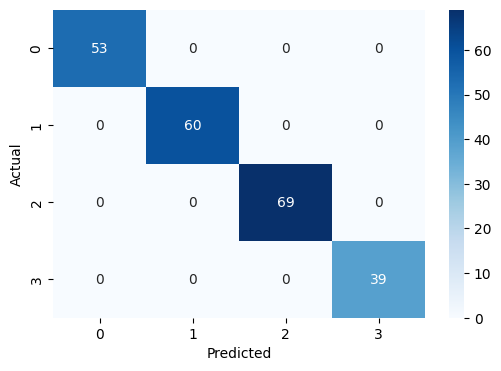

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Hyperparameter Tuning with RandomizedSearchCV
We will tune the model using RandomizedSearchCV to improve its performance by finding the best set of hyperparameters.

In [9]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(50, 201, 50),
    'max_depth': np.arange(3, 6),
    'learning_rate': np.linspace(0.01, 0.2, 5),
    'gamma': np.linspace(0, 0.3, 4),
    'subsample': np.linspace(0.8, 1.0, 3)
}

# RandomizedSearchCV with 25 iterations
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
                                   n_iter=25, scoring='accuracy', cv=5, verbose=1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_:.2f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': np.float64(0.9), 'n_estimators': np.int64(50), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.2), 'gamma': np.float64(0.0)}
Best cross-validation accuracy: 0.99


## Final Model Training and Evaluation
Using the best parameters from RandomizedSearchCV, we will train the final model and evaluate it on the test data.

Final Test Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        60
           2       1.00      1.00      1.00        69
           3       1.00      1.00      1.00        39

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221



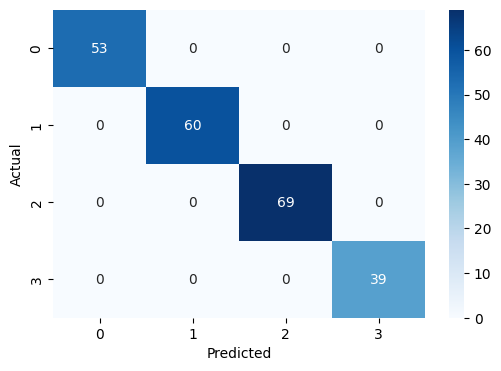

In [10]:
# Initialize XGBoost model with the best parameters
best_model = xgb.XGBClassifier(
    subsample=0.9, 
    n_estimators=50, 
    max_depth=3, 
    learning_rate=0.2, 
    gamma=0.0, 
    random_state=42
)

# Train the model on the training data
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {accuracy:.2f}")

# Detailed classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Cross-Validation Results
To ensure that the model generalizes well, we used cross-validation during hyperparameter tuning. The best cross-validation accuracy was 99%, indicating that the model performs consistently across different data splits.

## Feature Importance
We will plot the feature importance to understand which features play a crucial role in the model's predictions.

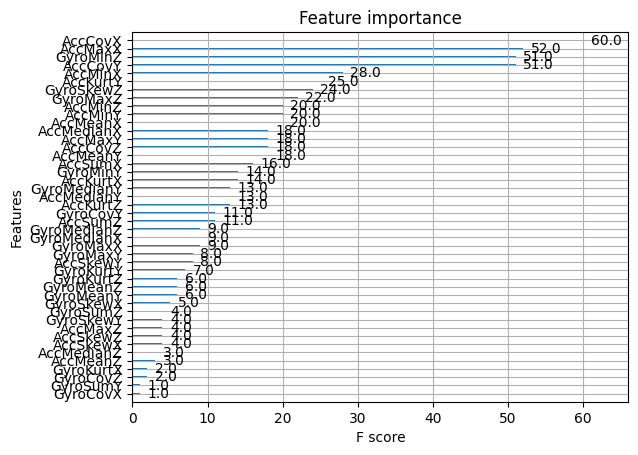

In [11]:
# Plot feature importance
xgb.plot_importance(best_model)
plt.show()

## Conclusion
We successfully built an autonomous driving safety predictor using the XGBoost algorithm. After hyperparameter tuning, the model achieved a cross-validation accuracy of 99% and performed excellently on the test data with a final accuracy of 100 %.

### Next Steps:
- Deploy the model for real-time predictions.
- Use SHAP values for explainability.
- Further optimize the model for new data.